In [129]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("/home/muncok/DL/projects/")

In [3]:
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
from sv_system.data.dataloader import init_default_loader
from sv_system.data.dataset import SpeechDataset

### Configuration

In [8]:
from sv_system.utils import secToFrames, secToSample
from sv_system.utils.parser import test_config
si_config = test_config('tdnn')

In [10]:
# input audio configuration
si_config['input_clip'] = True
si_config['input_length'] = secToSample(3)
si_config['input_frames'] = secToFrames(3)
si_config['splice_frames'] = secToFrames(0.1)
si_config['input_format'] = 'fbank'
si_config['data_folder'] = "/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/"

### Embedding Fucntion

In [280]:
import torch
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def lda_on_tensor(tensor, lda):
    return torch.from_numpy(lda.transform(tensor.numpy()).astype(np.float32))

def embeds_utterance(opt, val_dataloader, model, do_avg=True, lda=None):
    val_iter = iter(val_dataloader)
    model.eval()
    splice_dim = opt['splice_frames']
    embeddings = []
    labels = []
    for batch in tqdm_notebook(val_iter, total=len(val_iter)):
        x, y = batch
        time_dim = x.size(2)
        split_points = range(0, time_dim-(splice_dim+12), splice_dim)
        model_outputs = []
        for point in split_points:
            x_in = Variable(x.narrow(2, point, splice_dim+12))
            if not opt['no_cuda']:
                x_in = x_in.cuda()
            model_outputs.append(model.embed(x_in).cpu().data)
        model_output = torch.stack(model_outputs, dim=1)
        if do_avg:
            model_output = model_output.mean(1)
        if lda is not None:
            model_output = torch.from_numpy(lda.transform(model_output.numpy()).astype(np.float32))
        embeddings.append(model_output)
        labels.append(y.numpy())
    embeddings = torch.cat(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

### Model

In [11]:
si_config['batch_size'] = 64
si_config['num_workers'] = 32

In [432]:
from sv_system.model.TDNN import TdnnModel
model = TdnnModel(si_config, 1260, embed_mode=True)
model.load("../models/compare_train_methods/voxc/si_voxc_TdnnModel_3s_0.1s_fbank_full_frame.pt")
# model.load("../models/compare_train_methods/reddots/si_reddots_TdnnModel_3s_0.1s_fbank_full_frame.pt")
model.cuda()
# lda = pickle.load(open("../models/compare_train_methods/reddots/si_reddots_TdnnModel_3s_0.1s_fbank_full_frame.lda", "rb"))
lda = None

loaded from ../models/compare_train_methods/voxc/si_voxc_TdnnModel_3s_0.1s_fbank_full_frame.pt


##  Reddots Trial

In [433]:
err_type = {0:'TC', 1:'TW', 2:'IC', 3:'IW'}

In [232]:
ndx = pd.read_pickle("../dataset/dataframes/reddots//m_part4_tp/m_part4_tp_ndx.pkl")
trn = pd.read_pickle("../dataset/dataframes/reddots//m_part4_tp/m_part4_tp_trn.pkl")

### Embeddings

#### for segment-level

In [434]:
sample_audios = trn.sample(n=5)
dataset = SpeechDataset.read_df(si_config, sample_audios, "test")
dataloader = init_default_loader(si_config, dataset, shuffle=False)
embeddings, _ = embeds_utterance(si_config, dataloader, model, do_avg=False, lda=lda)

In [425]:
labels = np.arange(0, embeddings.size(0))
labels = np.repeat(np.expand_dims(labels, axis=1), embeddings.size(1), axis=1).flatten()

#### for utterance-level

In [274]:
sample_audios = trn[~trn.isin(['m0060', 'm0021', 'm0002'])].groupby('id').apply(lambda x: x.sample(n=5))
dataset = SpeechDataset.read_df(si_config, sample_audios, "test")
dataloader = init_default_loader(si_config, dataset, shuffle=False)

In [284]:
labels = np.arange(0, len(sample_audios.id.unique()))
labels = np.repeat(np.expand_dims(labels, axis=1), 5, axis=1).flatten()

In [298]:
embeddings, _ = embeds_utterance(si_config, dataloader, model, do_avg=True, lda=lda)

### T-SNE

In [299]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [300]:
pca = PCA(n_components=50)
if embeddings.dims() == 3:
    embeddings = embeddings.view(-1, embeddings.size(2))
pca_result = pca.fit_transform(embeddings) 

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.000s...
[t-SNE] Computed neighbors for 160 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 18.675981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.704525
[t-SNE] Error after 300 iterations: 0.540628


In [301]:
pylab.rcParams['figure.figsize'] = (8, 8)

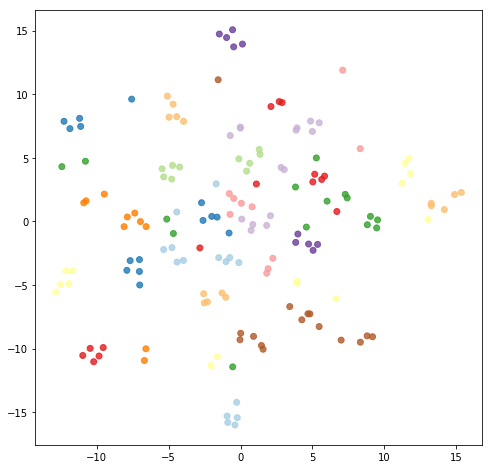

In [302]:
plt.scatter(
    x=tsne_pca_results[:,0], 
    y=tsne_pca_results[:,1], 
    c=labels, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.80)

### Distribution - Segment-level

In [435]:
embeddings.shape

torch.Size([5, 26, 1024])

In [436]:
import itertools
embs = embeddings.split(1, dim=0)
intra_uttr_sims = []
for j in range(embeddings.size(0)):
    emb = embeddings[j]
    it = itertools.combinations(emb, 2)
    for a, b in it:
        sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        intra_uttr_sims.append(sim)

In [437]:
inter_uttr_sims = []
for i, emb in enumerate(embs):
    other_embeddings = embeddings[i:].view(-1, 1024)
    randperm = np.random.randint(0, other_embeddings.size(0))
    other_segments = other_embeddings
    print(len(other_segments))
    for a, b in itertools.product(emb, other_segments):
        sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        inter_uttr_sims.append(sim)

130
104
78
52
26


In [438]:
def data_to_hist(data):
    hist, bin_edges = numpy.histogram(data, density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    return hist, bin_centres

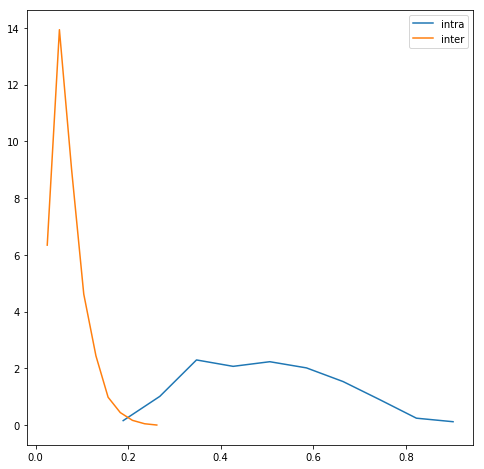

In [439]:
hist, bin_centres = data_to_hist(intra_uttr_sims)
plt.plot(bin_centres, hist, label='intra')
hist, bin_centres = data_to_hist(inter_uttr_sims)
plt.plot(bin_centres, hist, label='inter')
plt.legend()

In [446]:
inter_uttr_sims

[array([0.21519113, 0.17737202, 0.1753124 , 0.17451343, 0.15013932,
        0.12758918, 0.08405919, 0.08618761, 0.05688708, 0.06728774,
        0.08363066, 0.07488648, 0.08312927, 0.08360326, 0.08365704,
        0.09369054, 0.06320312, 0.05349684, 0.0622225 , 0.07610763,
        0.08593789, 0.06970812, 0.08557279, 0.10658595, 0.08654603,
        0.11256177], dtype=float32),
 array([0.19539014, 0.1953471 , 0.19299604, 0.18653189, 0.16861434,
        0.14158611, 0.09710991, 0.1013297 , 0.06725637, 0.07353989,
        0.09141618, 0.08589788, 0.09486098, 0.09914887, 0.08813629,
        0.09181765, 0.07579629, 0.06683347, 0.07685353, 0.09082814,
        0.09878854, 0.06297933, 0.08166046, 0.10838053, 0.08797458,
        0.11273226], dtype=float32),
 array([0.1783843 , 0.17826863, 0.21148539, 0.19805919, 0.17468569,
        0.13137646, 0.09750716, 0.08559014, 0.0576169 , 0.06924056,
        0.08373298, 0.07555851, 0.08111224, 0.09215239, 0.07836352,
        0.07293188, 0.0660055 , 0.06751266

Fitted mean =  0.3267558402098739
Fitted standard deviation =  -0.11403347037113129


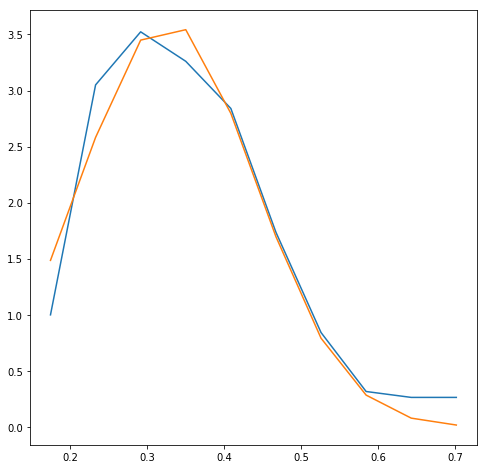

In [349]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define some test data which is close to Gaussian
data = np.array(sims)

hist, bin_edges = numpy.histogram(data, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='Test data')
plt.plot(bin_centres, hist_fit, label='Fitted data')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print ('Fitted mean = ', coeff[1])
print ('Fitted standard deviation = ', coeff[2])

plt.show()